In [1]:
import sys
import os
import joblib

# Add the parent directory (one level up) to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

from modules import model, dataset_design, feature_extractor

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

from sklearn.svm import SVC
# from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import joblib
import os

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")


In [2]:
#load data and design train test sets using module
dd = dataset_design.Dataset_designer()
raw_data = dd.extract('../data_sources/raw_data_v1.0.parquet')
data = dd.sample(raw_data, random_state = 50)
desc = dd.describe()
print(desc)
dd.load(data, desc['Train default storage'], desc['Test default storage'])

{'version': 'v1.0', 'Train default storage': '../data_sources/train_data_v1.0.parquet', 'Test default storage': '../data_sources/test_data_v1.0.parquet', 'description': {'No. Train Samples': 1343799, 'Train set fraud/no fraud split': '5876 / 1337923', 'No. Test Samples': 139073, 'fraud/no fraud split': '620 / 138453'}}
Train data saved to ../data_sources/train_data_v1.0.parquet
Test data saved to ../data_sources/test_data_v1.0.parquet


In [3]:
#use feature extractor to extract features
fe = feature_extractor.Feature_Extractor()
data_train_test, _ = fe.transform(data[0], data[1])
desc = fe.describe()

Columns with high correlations:


In [4]:
#extract data from
X_train, y_train, X_test, y_test = data_train_test

In [6]:
#print out data information
print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")

#column names
print(f"Feature Names: {X_train.columns}")

X train shape: (1343124, 18)
y train shape: (1343124,)
X test shape: (138998, 18)
y test shape: (138998,)
Feature Names: Index(['trans_diff', 'day_of_trans', 'hour_of_trans', 'month_of_trans', 'age',
       'state', 'merchant', 'category', 'sex', 'city', 'zip', 'job', 'amt',
       'lat', 'long', 'city_pop', 'merch_lat', 'merch_long'],
      dtype='object')


# Preprocessing steps #

1. Scale numerical columns using sklearn standard scaler.

2. Use SMOTE for oversampling the minority class.  


In [7]:
# Define categorical and numerical columns
categorical_cols = ['state', 'merchant', 'category', 'sex', 'city', 'zip', 'job']
numerical_cols = ['trans_diff', 'day_of_trans', 'hour_of_trans', 'month_of_trans', 'age', 'amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']

#preprocessor that scales the numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ])

#smote method for oversampling fraud transaction class
smote = SMOTE(random_state = 42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Models #

1. Logistic Regression with balanced class weight.
2. Random Forest
3. Linear Discriminant Analysis
4. SGD classifier

In [8]:
# Define models
logistic_regression = LogisticRegression(class_weight='balanced', random_state=42)
random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)
lda = LinearDiscriminantAnalysis()
sgd_classifier = SGDClassifier(loss='log_loss',class_weight='balanced', random_state=42)

# Create pipelines for each model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', logistic_regression)
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', random_forest)
])

lda_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lda)
])

sgd_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', sgd_classifier)
])

# Train and fit models #

### Logistic Regression ###

Model: Logistic Regression
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97    138378
         1.0       0.06      0.73      0.11       620

    accuracy                           0.95    138998
   macro avg       0.53      0.84      0.54    138998
weighted avg       0.99      0.95      0.97    138998

[[131158   7220]
 [   167    453]]


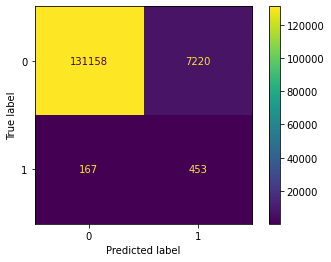

In [13]:
# Train the model
lr_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = lr_pipeline.predict(X_test)
    
# Evaluation metrics
print(f"Model: Logistic Regression")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()


In [14]:
#save model
model_name = 'logistic_regression'  # Example model name
model_version = 'v1'
model_path = f'../storage/models/artifacts/{model_name}_{model_version}.pkl'
joblib.dump(lr_pipeline, model_path)

['../storage/models/artifacts/logistic_regression_v1.pkl']

In [15]:
#save history of the model
# Predict on test set
y_pred = lr_pipeline.predict(X_test)
report = classification_report(y_test, y_pred, output_dict = True)
ac = accuracy_score(y_test, y_pred)

# Example of an existing DataFrame (you can replace this with your actual DataFrame)
model_history_df = pd.DataFrame(columns=['Model', 'Version', 'Precision', 'Recall', "Accuracy"])
model_data = {
    'Model': model_name,
    'Version': model_version,
    'Precision': report['1.0']['precision'],
    'Recall': report['1.0']['recall'],
    'Accuracy': ac
}

#append data to history data frame
logistic_df = pd.DataFrame(model_data, index = [0])
model_history_df = pd.concat([model_history_df, logistic_df], ignore_index = True)

#save dataframe
model_history_df.to_csv("../storage/models/model_history.csv", index = False)

### Random Forest ###

Model: Random Forests
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    138378
         1.0       0.12      0.63      0.20       620

    accuracy                           0.98    138998
   macro avg       0.56      0.80      0.60    138998
weighted avg       0.99      0.98      0.99    138998

[[135583   2795]
 [   232    388]]


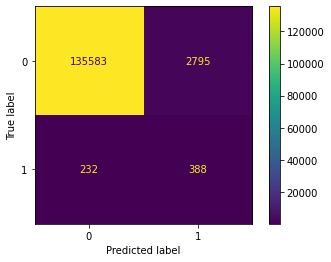

In [16]:
# Train the model
rf_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = rf_pipeline.predict(X_test)
    
# Evaluation metrics
print(f"Model: Random Forests")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()

In [17]:
#save model
model_name = 'random forest'  # Example model name
model_version = 'v1'
model_path = f'../storage/models/artifacts/{model_name}_{model_version}.pkl'
joblib.dump(rf_pipeline, model_path)

['../storage/models/artifacts/random forest_v1.pkl']

In [18]:
#save history of the model
# Predict on test set
y_pred = rf_pipeline.predict(X_test)
report = classification_report(y_test, y_pred, output_dict = True)
ac = accuracy_score(y_test, y_pred)

# Example of an existing DataFrame (you can replace this with your actual DataFrame)
model_data = {
    'Model': model_name,
    'Version': model_version,
    'Precision': report['1.0']['precision'],
    'Recall': report['1.0']['recall'],
    'Accuracy': ac
}

#append data to history data frame
random_forest_df = pd.DataFrame(model_data, index = [0])
model_history_df = pd.concat([model_history_df, random_forest_df], ignore_index = True)

#save dataframe
model_history_df.to_csv("../storage/models/model_history.csv", index = False)

### Linear Discriminant Analysis ###

Model: Linear Discriminant Analysis
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    138378
         1.0       0.10      0.65      0.18       620

    accuracy                           0.97    138998
   macro avg       0.55      0.81      0.58    138998
weighted avg       0.99      0.97      0.98    138998

[[134937   3441]
 [   217    403]]


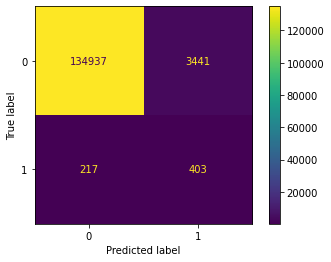

In [19]:
# Train the model
lda_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = lda_pipeline.predict(X_test)
    
# Evaluation metrics
print(f"Model: Linear Discriminant Analysis")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()


In [20]:
#save model
model_name = 'lda'  # Example model name
model_version = 'v1'
model_path = f'../storage/models/artifacts/{model_name}_{model_version}.pkl'
joblib.dump(lda_pipeline, model_path)

['../storage/models/artifacts/lda_v1.pkl']

In [21]:
#save history of the model
# Predict on test set
y_pred = lda_pipeline.predict(X_test)
report = classification_report(y_test, y_pred, output_dict = True)
ac = accuracy_score(y_test, y_pred)

# Example of an existing DataFrame (you can replace this with your actual DataFrame)
model_data = {
    'Model': model_name,
    'Version': model_version,
    'Precision': report['1.0']['precision'],
    'Recall': report['1.0']['recall'],
    'Accuracy': ac
}

model_history_df = pd.read_csv("../storage/models/model_history.csv")

#append data to history data frame
lda_df = pd.DataFrame(model_data, index = [0])
model_history_df = pd.concat([model_history_df, lda_df], ignore_index = True)

#save dataframe
model_history_df.to_csv("../storage/models/model_history.csv", index = False)

### SGD Classifier ###

Model: Linear Discriminant Analysis
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97    138378
         1.0       0.06      0.73      0.11       620

    accuracy                           0.95    138998
   macro avg       0.53      0.84      0.54    138998
weighted avg       0.99      0.95      0.97    138998

[[131308   7070]
 [   166    454]]


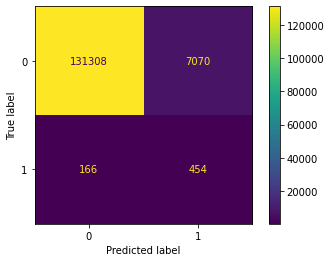

In [9]:
# Train the model
sgd_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = sgd_pipeline.predict(X_test)
    
# Evaluation metrics
print(f"Model: Linear Discriminant Analysis")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()


In [10]:
#save model
model_name = 'sgd_classifier'  # Example model name
model_version = 'v1'
model_path = f'../storage/models/artifacts/{model_name}_{model_version}.pkl'
joblib.dump(sgd_pipeline, model_path)

['../storage/models/artifacts/sgd_classifier_v1.pkl']

In [11]:
#save history of the model
# Predict on test set
y_pred = sgd_pipeline.predict(X_test)
report = classification_report(y_test, y_pred, output_dict = True)
ac = accuracy_score(y_test, y_pred)

# Example of an existing DataFrame (you can replace this with your actual DataFrame)
model_data = {
    'Model': model_name,
    'Version': model_version,
    'Precision': report['1.0']['precision'],
    'Recall': report['1.0']['recall'],
    'Accuracy': ac
}

model_history_df = pd.read_csv("../storage/models/model_history.csv")

#append data to history data frame
sgd_df = pd.DataFrame(model_data, index = [0])
model_history_df = pd.concat([model_history_df, sgd_df], ignore_index = True)

#save dataframe
model_history_df.to_csv("../storage/models/model_history.csv", index = False)

### Random Forest Pretrained model with variable threshold ###

One method of increasing the precision would be by using a variable threshold.

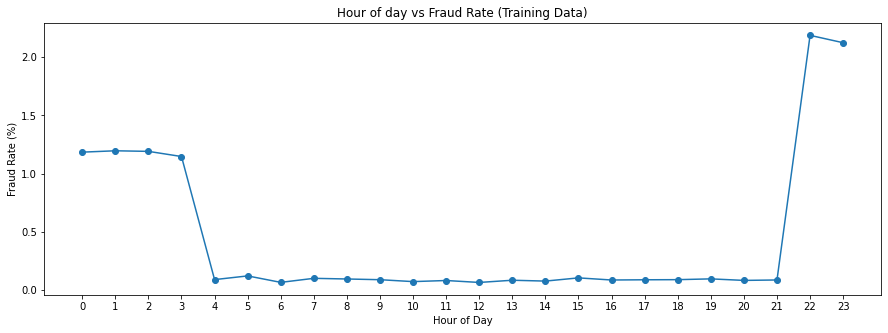

In [129]:
#checking out the training data
train_data = X_train.copy()
train_data['is_fraud'] = y_train

hour_count_df = train_data.groupby(['hour_of_trans', 'is_fraud'])['is_fraud'].count().unstack(fill_value=0)
hour_count_df['fraud_rate'] = hour_count_df[1] / hour_count_df[0] * 100

#plot the data
plt.figure(figsize = (15, 5))
plt.title('Hour of day vs Fraud Rate (Training Data)')
plt.plot(hour_count_df.index, hour_count_df['fraud_rate'])
plt.scatter(hour_count_df.index, hour_count_df['fraud_rate'])
plt.xticks(hour_count_df.index)
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.show()

Looking at the training fraud rate, we can see that between 21 and 4 hours there is a high fraud rate. So we will use a lower threshold for predicting a fraud ratio if the transaction is during this time frame in order to make sure we catch more fraudulent transactions. 

Now let's run this on the testing data and calculate the precision and recall. 

In [172]:
#load already trained rf pipeline
rf_pipeline = joblib.load('../storage/models/artifacts/random forest_v1.pkl')
rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['trans_diff', 'day_of_trans',
                                                   'hour_of_trans',
                                                   'month_of_trans', 'age',
                                                   'amt', 'lat', 'long',
                                                   'city_pop', 'merch_lat',
                                                   'merch_long'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

Next let's get an idea about the relationship between the recall and precision to find the optimal threshold. Let's seperate the test data to validation and a final test set in order to avoid data leakage. 

In [173]:
#further seperate X_test and y_test in to validation and test set
X_valid, X_final_test, y_valid, y_final_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

#get fraud probability
fraud_probabilities_valid = rf_pipeline.predict_proba(X_valid)[:, 1]


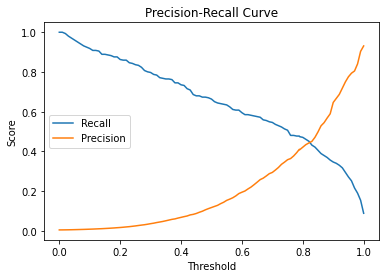

In [174]:
from sklearn.metrics import precision_recall_curve

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_valid, fraud_probabilities_valid)

# You can visualize the recall and precision curves
import matplotlib.pyplot as plt

plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


Looks like a threshold of 0.7 gives a close precesion and recall for our goal. Let's try close values with different thresholds at night and day to find if the model is able to give good results. Here we are usign validation data do this.

In [175]:
#threshold to use at night for fraud detection
night_threshold = 0.5
day_threshold = 0.95

X_valid['probabilities'] = fraud_probabilities_valid
night_mask = (X_valid['hour_of_trans'] > 21) | (X_valid['hour_of_trans'] < 4)
# Step 5: Apply thresholds based on the mask
X_valid.loc[night_mask, 'y_pred'] = (fraud_probabilities_valid[night_mask] >= night_threshold).astype(int)
X_valid.loc[~night_mask, 'y_pred'] = (fraud_probabilities_valid[~night_mask] >= day_threshold).astype(int)
y_pred = X_valid['y_pred'].to_list()

Model: Random Forests with variable thresholds
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     69193
         1.0       0.34      0.60      0.44       306

    accuracy                           0.99     69499
   macro avg       0.67      0.80      0.72     69499
weighted avg       1.00      0.99      0.99     69499

[[68835   358]
 [  121   185]]


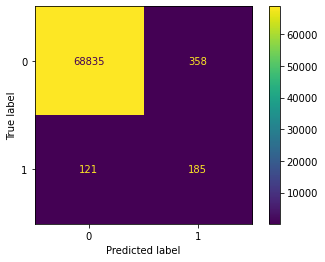

In [176]:
# Evaluation metrics
print(f"Model: Random Forests with variable thresholds")
print(classification_report(y_valid, y_pred))
print(confusion_matrix(y_valid, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix(y_valid, y_pred))
disp.plot()

Using the final test dataset to see if the model generalizes. 

In [177]:
fraud_probabilities_final_test = rf_pipeline.predict_proba(X_final_test)[:, 1]

In [179]:
X_final_test['probabilities'] = fraud_probabilities_final_test
night_mask = (X_final_test['hour_of_trans'] > 21) | (X_final_test['hour_of_trans'] < 4)
# Step 5: Apply thresholds based on the mask
X_final_test.loc[night_mask, 'y_pred'] = (fraud_probabilities_valid[night_mask] >= night_threshold).astype(int)
X_final_test.loc[~night_mask, 'y_pred'] = (fraud_probabilities_valid[~night_mask] >= day_threshold).astype(int)
y_pred_final_test = X_final_test['y_pred'].to_list()

Model: Random Forests with variable thresholds
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     69193
         1.0       0.34      0.60      0.44       306

    accuracy                           0.99     69499
   macro avg       0.67      0.80      0.72     69499
weighted avg       1.00      0.99      0.99     69499

[[68835   358]
 [  121   185]]


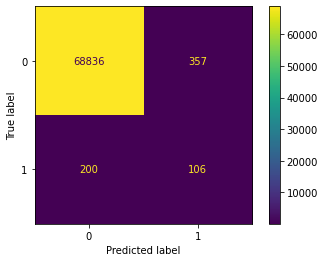

In [180]:
# Evaluation metrics
print(f"Model: Random Forests with variable thresholds")
print(classification_report(y_valid, y_pred))
print(confusion_matrix(y_valid, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix(y_valid, y_pred_final_test))
disp.plot()

The model achieves a slight increase in precision and the same recall as the older model.